# ニューラルネットワーク

[ゼロから作るDeep Learning](https://www.oreilly.co.jp/books/9784873117584/)を参考にニューラルネットワークを学ぶ

---
## 初期設定

In [2]:
import numpy as np
import matplotlib.pyplot as plt

---

## パーセプトロン

<br>

複数の値を入力すると0か1を出力するもの

**出力(0 or 1)** がどう決まるか  
→ 入力された値に定数を掛けた値の和が閾値を超えたか否か

定数は**重み($w$)** 、閾値は**バイアス($b$)** と呼ぶ

<br>

式にするとこうなる。

$$
y = \left\{
\begin{array}{ll}
1 & (x_1 w_1 + x_2 w_2 + \cdots + x_n w_n \geq b) \\
0 & (x_1 w_1 + x_2 w_2 + \cdots + x_n w_n  < b)
\end{array}
\right.
$$

<br>

内積を使って書くとこんな感じ

$$
y = \left\{
\begin{array}{ll}
1 & (x \cdot w - b \geq 0) \\
0 & (x \cdot w - b < 0)
\end{array}
\right.
$$

$x = (x_1, x_2, \cdots , x_n)$  
$w = (w_1, w_2, \cdots , w_n)$

<br>

入力をベクトル$x$、重みをベクトル$w$で表した。あと今後分かりやすくするために$b$を移行した。

<br>

パーセプトロンをpythonで実装してみる。

In [16]:
def perceptron(x1, x2):
    x = [x1, x2] # 入力をベクトル(1次元配列)に変換
    w = [0.5, 0.5] # 重み
    b = 0.7 # バイアス

    if np.dot(x, w) - b >= 0: # 内積がバイアス以上のとき
        return 1 # 1を出力
    else:
        return 0

入力は二つ、重みは二つとも0.5、バイアスは0.7とした

適当な値を入れてみる

In [17]:
perceptron(2, -1)

0

$(2 \times 0.5) + (-1 \times 0.5) = 0.5 < 0.7$ と、内積(0.5)がバイアス(0.7)を超えなかったので0が出力された

---
## 人工ニューロン

<br>

人間の脳の神経細胞(ニューロン)を数理的に再現したモデル。  
パーセプトロンの出力を実数全体に拡張したもの。内積にバイアスを足した値を**活性化関数**と呼ばれる関数に入れたときの値を出力する。

実装してみる

In [18]:
activation = lambda x: 2*x # 活性化関数

def neuron(x1, x2):
    x = [x1, x2]
    w = [0.5, 0.5]
    b = 2

    y = activation(np.dot(x, w) + b)
    return y

入力は2つ、重みは2つとも0.5、バイアスは2、活性化関数は$h(x)=2x$とした

適当に値を入れてみる

In [19]:
neuron(2, -3)

3.0

$((2 \times 0.5) + (-3 \times 0.5) + 2) \times 2 = 3$


---

## ニューラルネットワーク

<br>

人工ニューロンを何個も組み合わせたモデル。以下のように組み合わせる

[イメージ](https://takaolab.com/wp-content/uploads/2018/11/neural_network_image.png)
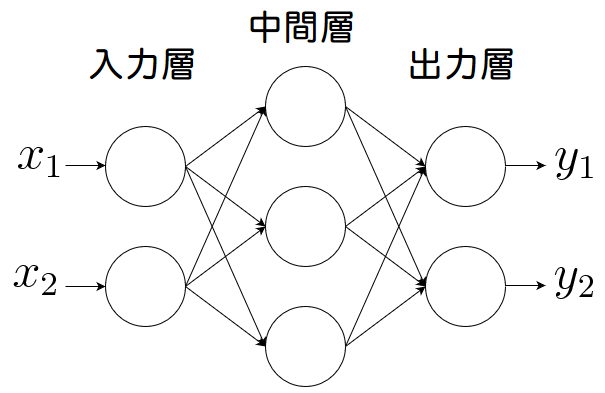  
[ニューラルネットワークとかディープラーニングって？ | たかおLab](https://takaolab.com/whats-nn-and-dnn/)

<br>

ニューラルネットワークは入力層、中間層(隠れ層)、出力層の3つで構成され、それぞれの層は**ノード**と呼ばれるもので構成されている。  
中間層の数は増やすことができ、2つ以上の中間層を持つものはディープニューラルネットワークとも呼ばれる。

<br>

入力層のノードには入力する値が直接入り、中間層、出力層のノードには人工ニューロンが入る。それぞれの人工ニューロンは、前の層からの出力を入力にとり、演算結果(出力)を次の層に渡す。これを繰り返し、最終的に出力層に届いた値がそのニューラルネットワークの出力となる。

### レイヤーを作る

NNを構成する層。Pythonで実装してみよう

In [5]:
from typing import Callable

class Layer:
    def __init__(self, n_input: int, n_output: int, activation: Callable):
        """重み、バイアスを標準正規分布に従って初期化"""
        self.w = np.random.randn(n_input, n_output)
        self.b = np.random.randn(n_output)
        self.activation = activation # 活性化関数を設定

    def __call__(self, x: np.ndarray) -> np.ndarray:
        """演算"""
        z = np.dot(x, self.w) + self.b # 内積をとってバイアスを足す
        y = self.activation(z) # 活性化関数にかける
        return y

レイヤーの演算は、行列を使うと簡潔に表せる。

例えば中間層の人工ニューロンの全てのパラメータを行列で表すと、中間層の出力はこのように表せる。

$$
Z = (z_1, z_2, z_3) = h(X \cdot W + B)
$$

$W$は全ての重みを並べた、入力層のノードの数$\times$中間層のノードの数の行列  
$B$は全てのバイアスを並べた、次元数が中間層のノードの数のベクトル

全ての層の演算は、このような行列の計算で表せる。

<br>

使ってみる

In [6]:
layer = Layer(10, 1, lambda x: x)

x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) # 入力する値
y = layer(x) # 演算
y

array([-23.58902466])

### NNを作る

レイヤーを組み合わせてNNを作るためのクラス

In [7]:
class SimpleNeuralNetwork:
    def __init__(self, *layers: Layer):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

使ってみよう。

さっきと同じように、10個の値を入れて1つの値が返ってくるモデル。  
活性化関数はシグモイド関数にしてみた

In [23]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

nn = SimpleNeuralNetwork(
    Layer(10, 32, sigmoid),
    Layer(32, 16, sigmoid),
    Layer(16, 1, sigmoid),
)

y = nn(x)
y

array([0.81076716])


---

## 活性化関数

<br>

活性化関数とはこのようなものだった

> 内積にバイアスを足した値を実際に出力する値に変換する関数を**活性化関数**という。

<br>

人工ニューロンに対して設定できるのでNNのノードごとに設定することもできるが、NNでは層ごとに決める。  
-> 行列を用いた並列的な処理を行うためと考えてよさそう

<br>


活性化関数には色々な種類がある

**参考**  
[活性化関数一覧 (2020) - Qiita](https://qiita.com/kuroitu/items/73cd401afd463a78115a)

<br>

### ステップ関数

<br>

0以下で0、0より大きい範囲では1を出力する関数。グラフが階段状となる関数を広く指す場合もある。  
パーセプトロンに使われている

$$
h(x) = \left\{
\begin{array}{ll}
1 & (x > 0) \\
0 & (x \leq 0)
\end{array}
\right. \\
$$

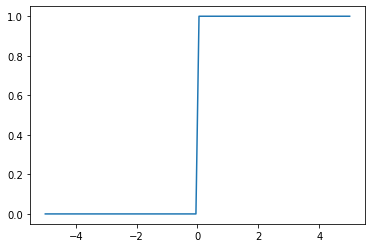

In [24]:
step = lambda x: x > 0
x = np.linspace(-5, 5, 100)
plt.plot(x, step(x));

<br>

### 恒等関数

<br>

回帰を行うNNの出力層に使われる場合が多い

$$
h(x) = x
$$

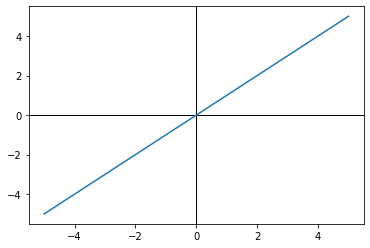

In [25]:
identity = lambda x: x
plt.axhline(color='black', lw=1)
plt.axvline(color='black', lw=1)
plt.plot(x, identity(x));

<br>

### シグモイド関数

<br>

ステップ関数を緩やかにしたようなもの

$$
h(x) = \frac{1}{1+e^{-x}}
$$

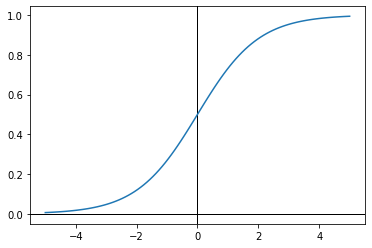

In [26]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
plt.axhline(color='black', lw=1)
plt.axvline(color='black', lw=1)
plt.plot(x, sigmoid(x));

<br>

### tanh関数

<br>

ハイパボリックタンジェント。シグモイド関数を-1 ~ 1に拡張したようなもの

$$
h(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

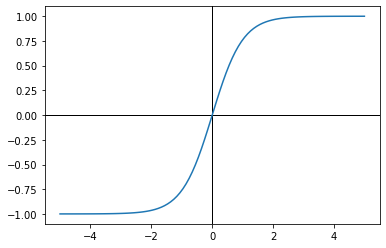

In [27]:
tanh = lambda x: (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
plt.axhline(color='black', lw=1)
plt.axvline(color='black', lw=1)
plt.plot(x, tanh(x));

<br>

### ReLU(Rectified Linear Unit) 関数

<br>

レルー。0以下のときは0、0より大きいときは恒等関数になる

$$
h(x) = \left\{
\begin{array}{ll}
x & (x > 0) \\
0 & (x \leq 0)
\end{array}
\right. \\
$$

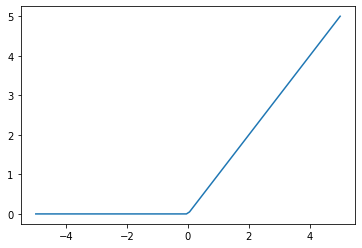

In [28]:
ReLU = lambda x: x if x > 0 else 0
plt.plot(x, [ReLU(x_) for x_ in x]);

ReLUにはいろんな種類がある

### ソフトマックス関数

<br>

分類を行うNNの出力層に使われる。

$$
h(x_k) = \frac{exp(x_k)}{\sum_{i=1}^{n} exp(x_i)}
$$

$exp(x) = e^x$  
$x_k$はその層の$k$番目の出力  
$n$はその層のノードの数

$x_k$が層全体の出力の中で占めている量を表す

In [29]:
softmax = lambda x: np.exp(x) / sum(np.exp(x))

(1, 0, 4)と入れてみると

In [30]:
x = np.array([1, 0, 4])
softmax(x)

array([0.04661262, 0.01714783, 0.93623955])

このようになる。割合ではないので(0.2, 0, 0.8)とはならない。ただ大小関係の情報は保持される

In [31]:
print(softmax(x - 1))
print(softmax(x + 50))
print(softmax(x - 100))

[0.04661262 0.01714783 0.93623955]
[0.04661262 0.01714783 0.93623955]
[0.04661262 0.01714783 0.93623955]


<br>

### 活性化関数の必要性

<br>

ここまで色々な活性化関数を紹介したが、そもそも活性化関数を使用する意味はあるのかという話。  
活性化関数を挟まず、内積にバイアスを足した値をそのまま出力する(=恒等関数を使用する)ではだめなのか。

**A.**  
活性化関数がないと層を重ねる意味がなくなる（非線形な表現が出来なくなる）

分かりやすい解説  
[活性化関数がディープラーニングに必要な理由 | あぱーブログ](https://blog.apar.jp/deep-learning/12216/)

-> 恒等関数みたいな、線形な関数を使うのはNG


---

## 学習

<br>

NNの重みとバイアスの適切な値を自動で求める事。最適化ともいう。入力に対して適切な出力が行えるようにする。

**例**  
入力：手書き数字の画像(の各ピクセルの色の数値)  
出力：書かれている数字

<br>

NNにおける重みとバイアスをまとめてパラメータと呼ぶ

NNに複雑なタスクをやらせようとすると、膨大な数のパラメータが必要になる。パラメータ1つ1つに適切な値を設定したい訳だが、手動で行っていたら我々が寿命を迎えてしまう。  
→ 最適パラメータは自動で設定する必要がある。

<br>

NNの学習の目標は、**損失**を小さくすることである。損失とは、ある値をNNに入力したときに**出てきてほしい**値と、実際にNNから出力された値の差のこと。誤差ともいう。

### 損失関数 (誤差関数)

損失を求める関数。出力値（実際にNNから出てきた値）と正解（出てきてほしい値）を入力すると、**近さ**が出力される。

<br>

主に使われている損失関数を紹介する。

$n = $ 出力する値の数(出力層のノードの数)  
$y = (y_1, y_2, \cdots, y_n) = $ 出力値  
$t = (t_1, t_2, \cdots, t_n) = $ 正解

#### 平均絶対誤差

<br>

$$
E = \frac{1}{n} \sum_{i=1}^{n} |y_i - t_i|
$$

各値の差の絶対値の平均。マンハッタン距離を次元数で割った感じ。

#### 平均二乗誤差

<br>

$$
E = \frac{1}{n} \sum_{i=1}^{n} (y_i - t_i)^2
$$

各値の差の二乗の平均。  
二乗することで損失と勾配の大きさが比例するので効率よく学習できる。

#### 二乗和誤差

$$
E = \frac{1}{2} \sum_{i=1}^{n} (y_i - t_i)^2
$$

平均二乗誤差で、nではなく2で割ったもの。  
微分をしたときに綺麗になるので2で割っている。

#### 交差エントロピー

<br>

$$
E = -\sum_{k=1}^{n} t_i\, log_{y_i}
$$

二つの確率分布の類似性を表す(類似している場合ほど小さい値をとる)。  
NNが分類のタスクを行う場合によく使われる

### 勾配法

<br>

最適化問題を解くアルゴリズムの一つ  
NNを学習させる代表的な手法

<br>

例えば、以下の関数を最小にすることを考える

$$
f(x_1, x_2) = x_1^2 + x_2^2
$$

こんな関数

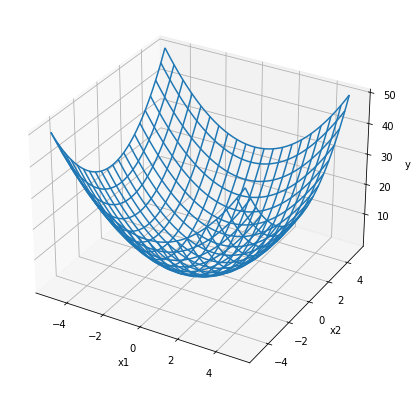

In [32]:
f = lambda x1, x2: x1**2 + x2**2

x1 = np.linspace(-5, 5, 100)
x2 = np.linspace(-5, 5, 100)
x1, x2 = np.meshgrid(x1, x2)
y = f(x1, x2)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(x1, x2, y, rcount=20, ccount=20)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y');

> 以下の関数を最小にすることを考える

**関数の最小値を求める**と置き換えて良い。今回は $f(0, 0) = 0$ が最小。  
こういう、最適化問題における「最小化（または最大化）したい関数」のことを**目的関数**とよぶ

<br>

ここで、関数の勾配（傾き）について考える。  
ある地点で勾配(傾き)を求めれば、どの方向に進めば小さくなるかが分かりそう

→ 適当に決めた初期値で勾配を求め、値を少しだけ更新し、また勾配を求め...と繰り返せば、最終的に最小値へたどり着きそう

<br>

実際にやってみる

勾配は微分で求められる。今回は多変数関数なので、各変数で偏微分を行う。  
といっても数学的な計算を行う訳ではなく、各変数に微小な値を足した際の変化率で求める

In [33]:
x1, x2 = -3, 3
y = f(x1, x2)
print(f'初期値: ', (x1, x2))

# 微小な値 (0.0001)
h = 1e-4

# 微小な値を足した際の変化率
grad1 = (f(x1 + h, x2) - f(x1, x2)) / h
grad2 = (f(x1, x2 + h) - f(x1, x2)) / h

print('勾配: ', (grad1, grad2))

初期値:  (-3, 3)
勾配:  (-5.99990000001327, 6.000099999994291)


$x_1$軸方向の勾配は約-6、$x_2$軸方向の勾配は約6であった  
計算で求めても一致する

$f(x_1, x_2) = x_1^2 + x_2^2$

$$
\frac{\partial f}{\partial x_1} = 2x_1
$$

$$
\frac{\partial f}{\partial x_2} = 2x_2
$$

$x_1, x_2$に-3, 3を代入すると-6, 6になる

<br>
<br>

勾配が負のとき、変数の値を増やせば今より小さい場所に行ける。  
勾配が正のとき、変数の値を減らせば今より小さい場所に行ける。

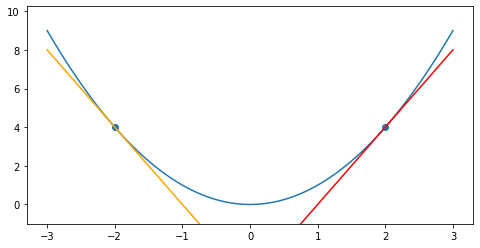

In [34]:
y = lambda x: x**2
l1 = lambda x: 4*(x - 2) + 4
l2 = lambda x: -4*(x + 2) + 4
x = np.linspace(-3, 3, 100)
plt.figure(figsize=(8, 4))
plt.plot(x, y(x))
plt.plot(x, l1(x), color='red')
plt.plot(x, l2(x), color='orange')
plt.scatter([-2, 2], [4, 4])
plt.ylim(-1);

$x_1$の勾配(-6)は負なので値を増やす。$x_2$の勾配(6)は正なので値を減らす。

このとき、勾配が急(絶対値が大きい)な場合は値を大きく更新し、勾配が緩やかな場合は値を小さく更新するようにすれば、効率よく最小値に向かえそう。

→ 勾配に定数をかけた値を変数から引く。この定数を**学習率**とよぶ。学習率は基本的に0 ~ 1の値を設定する。

In [35]:
r = 0.1 # 学習率
h = 1e-4 # 微小な値

# 経過の記録
log = [[x1, x2]]

# 20回繰り返す
n = 20

for _ in range(n):
    # 勾配
    grad1 = (f(x1 + h, x2) - f(x1, x2)) / h
    grad2 = (f(x1, x2 + h) - f(x1, x2)) / h

    # 座標の更新
    x1 -= grad1*r
    x2 -= grad2*r

    log.append([x1, x2])

x1, x2

(-0.034637068677444, 0.03453822159893161)

(0, 0)に近づいた

経過を見てみる

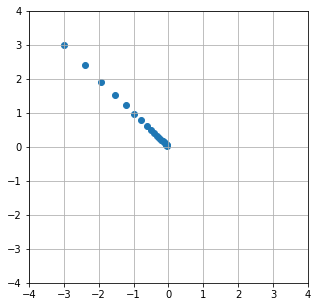

In [36]:
X, Y = np.array(log).T
plt.figure(figsize=(5,5))
plt.scatter(X, Y)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.grid()

徐々に近づいて行っているのが分かる

このように最小値を求める場合は**勾配降下法**、最大値を求める場合は**勾配上昇法**という  
(ほんとは極小値、極大値だけど)

<br>

ここで、目的関数をNNの損失関数とし、変数をNNのパラメータ（重みとバイアス）とすると、勾配法でNNの学習が行えることが分かる。

<br>

例えば、入力する値の例と、それを入力したときに出力されてほしい値(正解)の組を1セット用意する。このとき、NNにその値を入力したときに、用意した正解に近い値を出力するパラメータは、勾配法で求められる。  
NNの出力と用意した正解との差を最小にするパラメータを、勾配降下法で求めればよい。

例として、1,2,3を入力すると4を出力するNNを作る

<br>

まずNNの実装。中間層は1つで、ノードは10個にした(適当)。損失関数は、4との差をそのまま出力するようにする。

In [78]:
# 入力層、中間層、出力層のノードの数
n_input, n_hidden, n_output = 3, 10, 1

# 活性化関数
identity = lambda x: x # 恒等関数
sigmoid = lambda x: 1 / (1 + np.exp(-x)) # シグモイド関数

nn = NeuralNetwork(
    Layer(n_input, n_hidden, sigmoid),
    Layer(n_hidden, n_output, identity)
)

# 損失関数
x = np.array([1, 2, 3]) # 入力値
def return_loss():
    y, = nn(x)
    loss = abs(4 - y)
    return loss

初期値での出力

In [79]:
y, = nn(x)
print('出力値: ', y)
print('損失: ', return_loss())

出力値:  1.5828008710574126
損失:  2.4171991289425874


学習させて、これを4に近づける

In [80]:
def gradient(params):
    """入力したパラメータの勾配を求める関数"""
    h = 1e-4
    grad = np.zeros_like(params)
    for idx in np.ndindex(params.shape):
        tmp = params[idx] # 現在の値

        # 現在のパラメータでの損失
        loss1 = return_loss()

        # 微小な値を足したパラメータでの損失
        params[idx] += h
        loss2 = return_loss()

        # 勾配を保存
        grad[idx] = (loss2 - loss1) / h

        # 値を元に戻す
        params[idx] = tmp

    return grad

# 記録用
loss = [return_loss()]

def learning(n_steps, lr=0.01):
    # 各レイヤーのパラメータ
    W1 = nn.layers[0].w
    W2 = nn.layers[1].w
    B1 = nn.layers[0].b
    B2 = nn.layers[1].b

    for _ in range(n_steps):
        # 各パラメータの勾配
        grad_w1 = gradient(W1)
        grad_w2 = gradient(W2)
        grad_b1 = gradient(B1)
        grad_b2 = gradient(B2)

        # 各パラメータの更新
        W1 -= lr * grad_w1
        W2 -= lr * grad_w2
        B1 -= lr * grad_b1
        B2 -= lr * grad_b2

        loss.append(return_loss())

In [81]:
# 100回学習
learning(100)

nn(x)

array([4.03551642])

ほぼ4になった。損失の推移を見てみる

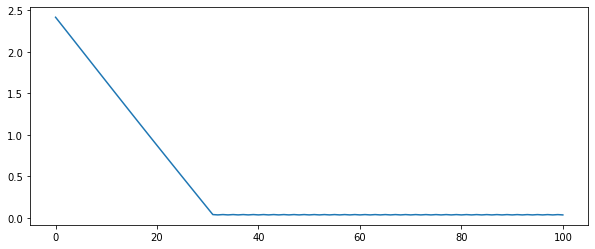

In [82]:
plt.figure(figsize=(10, 4))
plt.plot(loss);

徐々に損失が小さくなっているのが分かる

<br>

1,2,3を入れると4を出力するNNが出来たが、他の値を入れるとどうなるか試してみる

In [83]:
x2 = np.array([6, 7, 8])
nn(x2)

array([4.49907366])

6,7,8を入れても4に近い値が出てきた。ここで、6,7,8を入れると9が出力されるようにしたいと思った。どうすればよいかな。

→ 6,7,8を入れたときの9との差も損失に入れれば、6,7,8を入れたときに9が出力されるようにもできそう

In [84]:
# 損失関数
x1 = np.array([1, 2, 3])
x2 = np.array([6, 7, 8])
def return_loss():
    y1, = nn(x1)
    y2, = nn(x2)
    loss = abs(4 - y1) + abs(9 - y2)
    return loss

loss = [return_loss()]

In [90]:
learning(100)
nn(x1), nn(x2)

(array([4.00772753]), array([8.9262291]))

ちゃんとできた。損失も見てみる

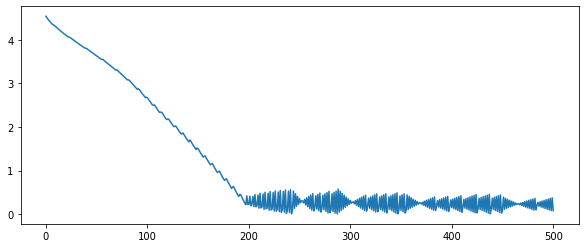

In [91]:
plt.figure(figsize=(10, 4))
plt.plot(loss);

ちゃんと小さくなってる

<br>

現在二つの学習データでNNを学習させた。では、学習データの数をもっと増やしたらどうなるだろう。

結論から言うと、NNが**汎用性**を持つようになる。

<br>

今回の場合は、「2,3,4 → 5」「-4,-5,-6 → -7」のように、同じ特徴を持ったデータをたくさん用意して学習を行う。そうすることでその特徴がパラメータに反映され、学習データに使われていないデータでも同じ特徴を持ったデータであれば適切に出力が行えるようになる。

#### 最急降下法

NNの学習方法の一つ。「勾配降下法」がこれを指す場合もある。

<br>

この手法では、すべての学習データに対する損失を求めてからパラメータを更新する。

パラメータの更新の際に、すべての学習データに対する損失を求め、平均や和などをとり、それが小さくなるように値を更新するということ。

<br>

しかし最急降下法には問題がある

- 局所解にハマりやすい

<br>

勾配法について聞いているときに感づいた人もいるかもしれない

「これ最小値じゃなくて極小値求めてね？」

実はその通りである。以下の図を見てほしい

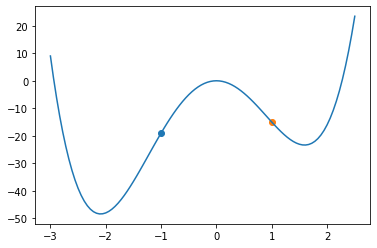

In [41]:
f = lambda x: 3 * x**4 + 2 * x**3 - 10 * 2 * x**2
x = np.linspace(-3, 2.5, 100)
plt.plot(x, f(x))
plt.scatter(-1, f(-1))
plt.scatter(1, f(1));

初期値が-1だった場合は最小値に辿り着くが、1だった場合は右の極小値に落ちてしまうため最小値には辿り着かない。

また、一回の更新ですべてのデータをNNに入力する必要があり、計算量が多いという欠点もある

<br>

#### 確率的勾配降下法

<br>

最急降下法の問題を解決したもの

**参考**  
[勾配降下法ってなんだろう - 白猫のメモ帳](https://shironeko.hateblo.jp/entry/2016/10/29/173634)

<br>

この手法では、学習データからランダムで取り出した一つのデータの損失を求め、パラメータを更新する。更新の際に一度の演算しか行わないため、計算量が減る。また、ランダムでデータを取り出すことで局所解にハマる可能性を減らせる(らしい)

<br>

しかしこれにも問題がある
- 最短で最適解に辿り着かない
- 外れ値の影響を受けやすい

<br>

#### ミニバッチ確率的勾配降下法

<br>

確率的勾配降下法の問題を解決したもの。最急降下法と確率的勾配降下法の折衷案みたいな感じ。

この手法では、用意した学習データから$n$個のデータをランダムで取り出してパラメータの更新を行う。すべてでも1個でもなく$n$個。いい感じの値を見つける感じ。この$n$は**バッチサイズ**と呼ぶ。損失は最急降下法同様、和や平均などをとる。

これで一通りの問題は解決できた。


---

## 誤差逆伝播法

勾配法における、勾配を数学的な計算で求める手法。  
「勾配法」の章に入れてもよかったが、NNの中では結構大きな分野なので分けた。

出力値と正解の差は「損失」でも「誤差」でもどっちでもいいが、この章ではタイトルに倣って「誤差」と指すことにする

<br>

勾配：誤差関数（損失関数）をパラメータで偏微分したもの  
数式で表すとこうなる

$$
\frac{\partial E}{\partial w}
$$

<br>

これを求めるために、**連鎖率**という考え方を使う。合成関数の微分を多変数に拡張したもの。  
NNの中で使われている関数（活性化関数や誤差関数）を一つ一つ微分すれば、連鎖率で全てのパラメータの勾配が求まる。

### 逆伝播

出力層から入力層に向かって行う演算

推論を行うとき、NNは入力層から出力層に向かって値を渡していった。これは**順伝播**という。で、これを逆から行うことを逆伝播という。  
逆伝播の際、各層は、受け取った値を微分した値を次の層に渡す。

### 実装

逆伝播を行えるレイヤーを実装してみよう。

#### シグモイド

まずはシグモイドレイヤーを実装する。  
シグモイド関数はこれ

$$
f(x) = \frac{1}{1 + e^{-x}}
$$

で、微分はこれ  
[シグモイド関数の微分 - Qiita](https://qiita.com/yosshi4486/items/d111272edeba0984cef2)

$$
f(x)' = (1 - f(x))f(x)
$$

In [62]:
class Sigmoid:
    def __call__(self, x: np.ndarray) -> np.ndarray:
        """順伝播"""
        self.y = 1 / (1 + np.exp(-x))
        return self.y

    def backward(self, x: np.ndarray) -> np.ndarray:
        """逆伝播"""
        return x * (1 - self.y) * self.y

    def update_params(self, lr) -> None:
        """パラメータの更新。ここでは使わない"""
        pass

#### 全結合層

重みとの内積とってバイアス足してる部分。パラメータを持つ層なので、少し工夫が必要。

In [56]:
class Affine:
    def __init__(self, n_input: int, n_output: int):
        self.w = np.random.randn(n_input, n_output)
        self.b = np.random.randn(n_output)

        # 勾配を保存しておく変数
        self.grad_w = None
        self.grad_b = None

    def __call__(self, x: np.ndarray) -> np.ndarray:
        """順伝播"""
        self.input = x # 逆伝播時に使うので、保存しておく
        y = np.dot(x, self.w) + self.b
        return y

    def backward(self, x: np.ndarray) -> np.ndarray:
        """逆伝播。勾配は保存しておく"""
        self.grad_w = np.dot(self.input.reshape(-1, 1), x.reshape(1, -1))
        self.grad_b = x
        return np.dot(x, self.w.T)

    def update_params(self, lr) -> None:
        """パラメータの更新"""
        self.w -= lr * self.grad_w
        self.b -= lr * self.grad_b

#### ニューラルネットワーク

初期化部分と順伝播は[さっきの](#nnを作る)と同じなので流用。

In [ ]:
class NeuralNetwork(SimpleNeuralNetwork):
    def backward(self, x: np.ndarray) -> None:
        """逆伝播"""
        for layer in self.layers[::-1]:
            x = layer.backward(x)

    def update_params(self, lr: float) -> None:
        """パラメータの更新"""
        for layer in self.layers:
            layer.update_params(lr)

#### 誤差関数

誤差関数もクラスとして実装しておこう。  
今回は二乗和誤差を使う。

$$
E = \frac{1}{2} \sum_{i=1}^{n} (y_i - t_i)^2
$$

$y_i$ での微分はこう

$$
E' = y_i - t_i
$$

In [108]:
class SSE:
    def __call__(self, y: np.ndarray, t: np.ndarray) -> np.ndarray:
        self.y = y
        self.t = t
        loss = ((y - t)**2).sum() / 2
        return loss

    def backward(self) -> np.ndarray:
        return self.y - self.t

#### 使ってみる

さっきと同じように、1,2,3を入れると4が返ってくるように学習させよう。

In [128]:
nn = NeuralNetwork(
    Affine(3, 10),
    Sigmoid(),
    Affine(10, 1),
)

sse = SSE()

x = np.array([1, 2, 3]) # 入力値
t = np.array([4]) # 正解
y, = nn(x)
loss = sse(y, t)
log = [loss] # 記録用

print('初期値での精度')
print('出力値: ', y)
print('誤差: ', loss)

初期値での精度
出力値:  -2.2489858862142786
損失:  19.524912303052623


学習させる

In [129]:
def learning(n_steps, lr=0.01):
    for _ in range(n_steps):
        y = nn(x) # 順伝播
        loss = sse(y, t) # 誤差の計算
        out = sse.backward() # 逆伝播（誤差）
        nn.backward(out) # 逆伝播（nn）
        nn.update_params(lr) # パラメータ更新

        log.append(loss) # 記録

In [130]:
n_steps = 50
lr = 0.01
learning(n_steps, lr)

学習後の精度
出力値:  3.9525537966967095
誤差:  0.0011255711039485884


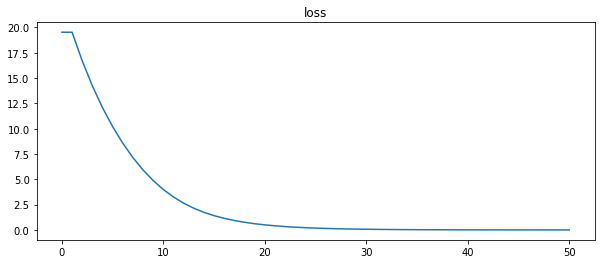

In [135]:
y, = nn(x)
loss = sse(y, t)

print('学習後の精度')
print('出力値: ', y)
print('誤差: ', loss)

plt.figure(figsize=(10, 4))
plt.title('loss')
plt.plot(log);


---

## 評価

学習させたモデルをどう評価するか。NNに限らず、機械学習全般に共通して言える章。

### 評価関数

NNの性能を表す関数。損失関数と違い、関数から出力された値が直接学習に使われることはない。

損失関数を使い、損失の小ささで評価を行うこともできるが、別の指標を使うときもある。  
例えば分類の場合は、精度(正答率)で測ることもできる。

**タスクに応じた評価関数まとめ**  
[機械学習で使われる評価関数まとめ - Qiita](https://qiita.com/monda00/items/a2ee8e0da51953c24da8)

### 過学習

NNが、学習データで良い性能を出すことに特化しすぎてしまい、汎用的な性能を失った状態。NNを同じデータで学習させすぎると過学習を起こすことがあるので、いい感じに調整する必要がある。

### テストデータ(評価データ)

学習に使用したデータを使用して評価を行うと、過学習を起こしているかが分からない。そこで、集めたデータの一部を評価用にし、そのデータは学習に使わないようにする。この評価用のデータを**テストデータ**とか**評価データ**とかいう。

学習したNNの性能を計るときは、学習データとテストデータの両方で評価を行う。

---
## 実装

<br>

以上の知識でNNの実装ができるので簡易的に実装してみよう。

<br>

### パラメータの初期化

<br>

重み、バイアスを初期化する。初期値は0~1の実数。ランダムで決める。  
引数には各層のノードの数を入力(入力層から順に)

初期化だけでなく、活性化関数と誤差関数の指定も行う。ここで指定した活性化関数は出力層でのみ使われる。

In [42]:
activetion_func = {
    'sigmoid': lambda x: 1 / (1 + np.exp(-x)), 
    'tanh': lambda x: (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)), 
    'softmax': lambda x: np.exp(x) / sum(np.exp(x), axis=-1)
}

loss_func = {
    'mse': lambda y, t: np.mean((y - t)**2),
    'cross_entropy': \
        lambda y, t: np.mean(-np.sum(t * np.log(y + 1e-7)))
}

def init(*sizes: int, activation_name: str, loss_name: str) -> None:
    """パラメータを初期化する関数"""
    # 各層の重み、バイアスを初期化し保存
    global W, B
    W, B = [], []
    for size1, size2 in zip(sizes[:-1], sizes[1:]):
        W.append(np.random.random((size1, size2)))
        B.append(np.random.random(size2))
    
    # 活性化関数、誤差関数を定義
    global activation, loss
    activation = activetion_func[activation_name]
    loss = loss_func[loss_name]

<br>

### 演算を行う関数

<br>

定義されているパラメータを使って演算を行う関数。入力はnumpy配列で行う。入力値が一つの場合もnumpy配列で入力する。

In [43]:
def predict(x: np.ndarray) -> np.ndarray:
    """演算を行う関数"""
    z = x
    for w, b in zip(W[:-1], B[:-1]):
        z = sigmoid(z @ w + b)
    y = activation(z @ W[-1] + B[-1])
    return y

<br>

### 勾配を求める関数

<br>

入力したパラメータの勾配を求める関数。入力は各層のパラメータの行列とする。  
パラメータの他に、使用する学習データも入力する。

In [44]:
def gradient(
    params: np.ndarray,
    x: np.ndarray,
    label: np.ndarray,
) -> np.ndarray:
    """入力したパラメータの勾配を求める関数"""
    h = 1e-4
    grad = np.zeros_like(params)
    for idx in np.ndindex(params.shape):
        tmp = params[idx] # 現在の値
        
        # 現在のパラメータでの損失
        y1 = loss(x, label)
        
        # 変更したパラメータでの損失
        params[idx] += h
        y2 = loss(x, label)
        
        # 勾配
        grad[idx] = (y2 - y1) / h
        
        params[idx] = tmp # 値を元に戻す

    return grad

<br>

### 学習を行う関数

<br>

入力された学習データをもとに学習を行う。学習アルゴリズムはミニバッチ確率的勾配降下法を使う。

学習データの他に学習率、バッチサイズ、エポック数を指定する。

エポック数とは、用意した学習データを何回繰り返して使用するかを示す値である。例えば最急降下法の場合、一度の更新に全ての学習データを使用するので、エポック数とパラメータを更新する回数は同じになる。  
ミニバッチ確率的勾配降下法の場合は、NNに入力したデータの数(演算を行った回数)が用意した学習データの数と一致した時点で1エポックとする。

**例**  
学習データ100, バッチサイズ25の場合 → パラメータを4回更新すると1エポック

**参考**  
[エポック(epoch)数とは【機械学習 / Deep Learning】 - St_Hakky’s blog](https://www.st-hakky-blog.com/entry/2017/01/17/165137)

In [45]:
def learning(
    x: np.ndarray,
    label: np.ndarray,
    epochs: int = 50,
    batch_size: int = 100,
    learning_rate: float = 1e-3
) -> None:
    """学習を行う関数"""
    # 1エポック毎に繰り返す回数
    n_per_epoch = int(len(x) / batch_size)
    
    # 二次元に変換
    if label.ndim == 1:
        label = label.reshape(-1, 1)
        
    for _ in range(epochs):
        for _ in range(n_per_epoch):
            # バッチサイズ分データを取り出す
            idx = np.random.choice(len(x), batch_size)
            sample_x = x[idx]
            sample_label = label[idx]

            # 勾配の計算
            W_grad = []
            B_grad = []
            for w, b in zip(W, B):
                W_grad.append(gradient(w, sample_x, sample_label))
                B_grad.append(gradient(b, sample_x, sample_label))

            # パラメータの更新
            for w, w_grad, b, b_grad in zip(W, W_grad, B, B_grad):
                w -= learning_rate * w_grad
                b -= learning_rate * b_grad

<br>

### クラスにまとめる

<br>

これらの変数や関数を一つのクラスにまとめる

In [46]:
class NeuralNetwork:
    _activetion_func = {
        'sigmoid': lambda x: 1 / (1 + np.exp(-x)),
        'tanh': lambda x: (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)), 
        'softmax': lambda x: np.exp(x) / sum(np.exp(x)),
        'identity': lambda x: x
    }

    _loss_func = {
        'mse': lambda y, t: np.mean((y - t)**2),
        'cross_entropy': \
            lambda y, t: np.mean(-np.sum(t * np.log(y + 1e-7)))
    }

    def __init__(self, *sizes: int, activation: str, loss: str):
        self.W, self.B = [], []
        for size1, size2 in zip(sizes[:-1], sizes[1:]):
            self.W.append(np.random.random((size1, size2)))
            self.B.append(np.random.random(size2))
            
        self._activation = self._activetion_func[activation]
        self._loss = self._loss_func[loss]

    def predict(self, x: np.ndarray) -> np.ndarray:
        z = np.array(x)
        for w, b in zip(self.W[:-1], self.B[:-1]):
            z = sigmoid(z @ w + b)
        y = self._activation(z @ self.W[-1] + self.B[-1])
        return y
    
    def _gradient(
        self,
        params: np.ndarray,
        x: np.ndarray,
        label: np.ndarray
    ) -> np.ndarray:
        h = 1e-4
        grad = np.zeros_like(params)
        for idx in np.ndindex(params.shape):
            tmp = params[idx]
            y1 = self._loss(self.predict(x), label)
            params[idx] += h
            y2 = self._loss(self.predict(x), label)
            grad[idx] = (y2 - y1) / h
            params[idx] = tmp
        return grad

    def learning(
        self,
        x: np.ndarray,
        label: np.ndarray,
        epochs: int = 50,
        batch_size: int = 32,
        learning_rate: float = 1e-3
    ) -> None:
        n_per_epoch = int(len(x) / batch_size)
        if label.ndim == 1:
            label = label.reshape(-1, 1)
        for n in range(epochs):
            for _ in range(n_per_epoch):
                idx = np.random.choice(len(x), batch_size)
                sample_x = x[idx]
                sample_label = label[idx]

                W_grad = []
                B_grad = []
                for w, b in zip(self.W, self.B):
                    W_grad.append(self._gradient(w, sample_x, sample_label))
                    B_grad.append(self._gradient(b, sample_x, sample_label))

                for w, w_grad, b, b_grad in zip(self.W, W_grad, self.B, B_grad):
                    w -= learning_rate * w_grad
                    b -= learning_rate * b_grad
            print(f'{n+1:>{len(str(epochs))}}epoc', 
                  f'loss:{self._loss(self.predict(x), label)}')

---
## 実践

<br>

実装したクラスを使って予測モデルを作ってみる

<br>

### 回帰

<br>

回帰の問題を解くNNを作る。

<br>

今回は、ある等差数列の値を3つ入力すると、それに続く値を出力するモデルを作る。

**例**

| 入力1 | 入力2 | 入力3 | 出力 |
| --- | --- | --- | --- |
| 1 | 2 | 3 | 4 |
| 1 | 0 | -1 | -2 |
| 1.2 | 2.4 | 3.6 | 4.8 |

<br>

#### 学習データの用意

<br>

上の入出力の組を大量に用意する。今回はプログラムで自動生成できるので適当に10000組用意する。

In [47]:
n = 10000
a = np.random.uniform(-3, 3, n) # 初項
d = np.random.uniform(-3, 3, n) # 公差

x = np.array([a, a + d, a + 2*d]).T
label = a + 3*d    

学習データの例

In [48]:
[print(x[i], '->', label[i]) for i in range(5)];

[ 1.67701411 -0.70289007 -3.08279425] -> -5.46269843106068
[2.43905049 4.24031281 6.04157513] -> 7.842837448492572
[-1.7426932  -2.12501933 -2.50734546] -> -2.8896715925496075
[0.1521228  3.14919601 6.14626923] -> 9.14334244396694
[-0.5602286  0.2931481  1.1465248] -> 1.999901500561477


分かり辛いが等差数列になっているはず

<br>

#### NNの構築

<br>

層の数や活性化関数など必要な情報を入力し、インスタンス化する。

- 中間層の数  
簡単なタスクなので1層で良さそう

- 中間層のノードの数  
簡単なタスクなのでそんなに多くなくて良さそう。10個ぐらいでいいかな？

- 出力層の活性化関数  
回帰問題なので恒等関数

- 損失関数  
分類問題ではないので平均二乗誤差

In [49]:
NN = NeuralNetwork(3, 10, 1, activation='identity', loss='mse')

**ちなみに**  
初期値での予測結果

In [50]:
NN.predict([-1, -2, -3])

array([0.75675121])

<br>

#### 学習

<br>

先程用意した学習データで学習を行う

In [51]:
%%time
NN.learning(x, label, epochs=20, batch_size=32, learning_rate=1e-2)
print()

 1epoc loss:2.751378618113095
 2epoc loss:1.2389912475394391
 3epoc loss:0.8023640263552677
 4epoc loss:0.5925770960561162
 5epoc loss:0.474028586322609
 6epoc loss:0.3819258467004144
 7epoc loss:0.32256103884232
 8epoc loss:0.2816911979176944
 9epoc loss:0.24437093196978152
10epoc loss:0.22006605779283914
11epoc loss:0.19610855707778801
12epoc loss:0.17883422859674014
13epoc loss:0.1583895424803983
14epoc loss:0.13966917330596385
15epoc loss:0.12642724219453852
16epoc loss:0.11215419277841261
17epoc loss:0.10197565945775555
18epoc loss:0.09246835439797309
19epoc loss:0.08193978218174658
20epoc loss:0.07355151280946041

CPU times: user 23.1 s, sys: 24.4 s, total: 47.5 s
Wall time: 14.4 s


損失が小さくなっているのが分かる

さっきの値を入力してみる

In [52]:
NN.predict([-1, -2, -3])

array([-4.40903205])

いい感じ。ほかの値も入れてみる

In [53]:
test = [[1, 2, 3], [2, -1, -4], [2.1, 3.2, 4.3]]
for t in test:
    print(t, '->', *NN.predict(t))

[1, 2, 3] -> 4.293359665180521
[2, -1, -4] -> -6.667661739772089
[2.1, 3.2, 4.3] -> 5.63103165039545


結構近い値が出せている。

ではこれはどうだろう

In [54]:
NN.predict([10, 20, 30])

array([13.53199189])

できてないね。

<br>

(調べてないから俺が考えただけ)
一般的に、NNでは絶対値の大きな値は扱わない。主に使われている活性化関数が0付近の値をとるからかな？ 学習や予測は正規化を行ってからやる場合が多いね。

<br>

### keras

<br>

pythonで機械学習を行うためのライブラリ。現在はtensorflowに導入されている。独立したものを使用することもできる。

In [55]:
from tensorflow import keras

モデルを定義。

In [56]:
from tensorflow.keras import models
model = models.Sequential()

2022-05-28 16:26:21.415166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-28 16:26:21.466455: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-05-28 16:26:21.466473: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-05-28 16:26:21.467009: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

kerasでモデルを構築する手順は、SequentialとFunctional APIの二通りがある。

Sequentialモデルは型にはまった手順でモデルを構築する。Sequentialは「順序通り」という意味。  
Functional APIは複雑な代わりに自由度が高く、複雑なモデルを構築する際に用いる。

<br>

Sequentialではmodelに層を順番に追加することでモデルを構築する。層を追加するときに、ノードの数や活性化関数を指定する。実は層にもいろいろな種類があったりする。  

**レイヤー一覧**  
[Coreレイヤー - Keras Documentation](https://keras.io/ja/layers/core/)

**活性化関数一覧**  
[活性化関数 - Keras Documentation](https://keras.io/ja/activations/)

<br>

最も一般的な層がDenseと呼ばれる全結合層。前の出力が全てこのレイヤーと繋がる。

In [57]:
from tensorflow.keras.layers import Dense

では1層目を追加してみる。1層目では0層目のノードの数(入力のする値の数)も指定する。

In [58]:
model.add(
    Dense(10, input_shape=(3,), activation='sigmoid')
)

次に2層目を追加する。今回はこれが出力層になる。

In [59]:
model.add(
    Dense(1, activation='linear')
)

ノードの数は1で活性化関数は恒等関数(linear)

一つ一つaddするのではなく、インスタンス生成の際にこのようにレイヤーをリストとして与えることもできる。

In [60]:
model = models.Sequential([
    Dense(10, input_shape=(3,), activation='sigmoid'),
    Dense(1, activation='linear')
])

中身を確認したい場合

In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                40        
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


層を追加し終わったら学習アルゴリズムと損失関数を指定する

**学習アルゴリズム一覧**  
[最適化 - Keras Documentation](https://keras.io/ja/optimizers/)

**損失関数一覧**  
[損失関数 - Keras Documentation](https://keras.io/ja/losses/)

In [62]:
model.compile(optimizer='SGD',
              loss='mean_squared_error')

SGD(確率的勾配降下法)  
SDGsみたいでうざいね

ちなみにこの確率的勾配降下法はミニバッチのやつ。普通のやつとか最急降下法とかにしたかったらバッチサイズいじればよし。ということで学習

In [63]:
%%time
model.fit(x, label, batch_size=32, epochs=20)

Epoch 1/20
313/313 [==============================] - 0s 655us/step - loss: 3.2929
Epoch 2/20
313/313 [==============================] - 0s 610us/step - loss: 0.4931
Epoch 3/20
313/313 [==============================] - 0s 597us/step - loss: 0.3129
Epoch 4/20
313/313 [==============================] - 0s 587us/step - loss: 0.2377
Epoch 5/20
313/313 [==============================] - 0s 593us/step - loss: 0.1946
Epoch 6/20
313/313 [==============================] - 0s 590us/step - loss: 0.1661
Epoch 7/20
313/313 [==============================] - 0s 590us/step - loss: 0.1477
Epoch 8/20
313/313 [==============================] - 0s 596us/step - loss: 0.1333
Epoch 9/20
313/313 [==============================] - 0s 595us/step - loss: 0.1231
Epoch 10/20
313/313 [==============================] - 0s 605us/step - loss: 0.1123
Epoch 11/20
313/313 [==============================] - 0s 590us/step - loss: 0.1048
Epoch 12/20
313/313 [==============================] - 0s 594us/step - loss: 0.0993
E

損失がちゃんと減っていってる。実行時間がさっきより早いのはちゃんと理由がある(後で触れる)

予測してみる

In [64]:
test = [[1, 2, 3], [2, -1, -4], [2.1, 3.2, 4.3]]
print(*model.predict(test))

1/1 [==============================] - 0s 46ms/step
[4.207512] [-6.6026797] [5.466271]


まあそれっぽくはなってる。

ちなみに1次元の入力は受け付けていない様子。

In [65]:
x_ = np.array([1, 2, 3])
model.predict(x_)

ValueError: in user code:

    File "/home/komiya/study/neural-network/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/home/komiya/study/neural-network/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/komiya/study/neural-network/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/home/komiya/study/neural-network/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/home/komiya/study/neural-network/.venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/komiya/study/neural-network/.venv/lib/python3.9/site-packages/keras/engine/input_spec.py", line 228, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_1" (type Sequential).
    
    Input 0 of layer "dense_2" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer "sequential_1" (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=int64)
      • training=False
      • mask=None


形状が(入力する数, 入力層のノードの数)でないといけないので、入力する数が1の時は`reshape()`しましょう

In [66]:
x_ = x_.reshape(1, -1)
model.predict(x_)

1/1 [==============================] - 0s 23ms/step


array([[4.207512]], dtype=float32)

<br>

### 分類

<br>

分類の問題を解くNNを作る。分類したいものを表した値を入力し、それがどのクラスタに属するかを分類する。

出力層のノードをクラスタの数だけ用意し、それぞれのクラスタに属する確率を各ノードから出力する。出力値の総和は1になる。これは出力層の活性化関数をソフトマックス関数にすることで実装できる。  
正解のクラスタに対応するノードを1、それ以外のノードを0とした配列がラベルとなる。

<br>

最初の方から例に出してきた手書き数字の分類を行う。

<br>

#### 学習データの用意

<br>

MNISTを使う。手書き数字の画像が大量に用意されたデータセット。kerasから取得できる。

In [67]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

(学習に使う画像, その答え), (評価に使う画像, その答え)

画像はこんな感じ

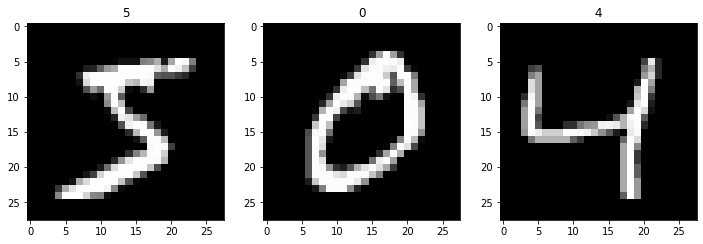

In [68]:
n = 3
plt.figure(figsize=(4*n, 4))
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.title(train_labels[i])
    plt.imshow(train_images[i], cmap='gray');

$28 \times 28$ピクセルの画像。各ピクセルの色の濃淡を数値化することで、画像を$28 \times 28$の配列として表している。このデータは、色の濃淡を0 ~ 255で表している。

In [69]:
train_images.shape

(60000, 28, 28)

$28 \times 28$の配列が60000個ある。これを学習させる

一方で正解データはこのようになっている。画像が表している数字が格納されているだけ。

In [70]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

<br>

#### 前処理

<br>

これらのデータはそのまま学習に使えるわけではなく、いくつかの処理を施す必要がある。

<br>

##### 平坦化

<br>

入力は一次元の配列でないといけないので、$28 \times 28$の配列を一次元にする。

In [71]:
train_images = train_images.reshape(len(train_images), -1)
test_images = test_images.reshape(len(test_images), -1)
train_images.shape

(60000, 784)

$28 \times 28$の配列を長さが784の一次元の配列に変換した

<br>

##### one-hotベクトル

<br>

ある要素が1で他の要素が全て0のベクトル。

> 正解のクラスタに対応するノードを1、それ以外のノードを0とした配列がラベルとなる。

数値をこの形に変換する

In [72]:
def one_hot(y, n):
    return np.array([[int(i == y_)  for i in range(n)] for y_ in y])

In [73]:
train_labels = one_hot(train_labels, 10)
test_labels = one_hot(test_labels, 10)

In [74]:
train_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

変換できた

<br>

#### NNの構築

<br>

NNを構築する。

入力する値は784個、出力する値は10個。中間層は2層でノードの数は両方とも100にする(適当)。

In [75]:
model = models.Sequential([
    Dense(100, input_shape=(784,), activation='sigmoid'),
    Dense(100, activation='sigmoid'),
    Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               78500     
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 10)                1010      
                                                                 
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


学習アルゴリズムはadamを使用。SGDの進化版みたいなやつ。  
損失関数は交差エントロピーを使用。分類問題なので。  

今回は評価関数も指定。学習結果が変わることはないが、学習中に表示されるようになるので分かりやすい。分類の正答率を指定した。複数指定することも可能。  
ちなみに'accuracy'もしくは'acc'とすると適切な評価関数を自動で決めてくれる。

In [77]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc'])

<br>

#### 学習

<br>

えい

In [78]:
%%time

model.fit(train_images, train_labels, batch_size=128, epochs=10)

Epoch 1/10
469/469 [==============================] - 1s 2ms/step - loss: 0.7540 - acc: 0.8194
Epoch 2/10
469/469 [==============================] - 1s 1ms/step - loss: 0.3339 - acc: 0.9047
Epoch 3/10
469/469 [==============================] - 1s 1ms/step - loss: 0.2930 - acc: 0.9124
Epoch 4/10
469/469 [==============================] - 1s 1ms/step - loss: 0.2728 - acc: 0.9178
Epoch 5/10
469/469 [==============================] - 1s 1ms/step - loss: 0.2637 - acc: 0.9198
Epoch 6/10
469/469 [==============================] - 1s 1ms/step - loss: 0.2502 - acc: 0.9244
Epoch 7/10
469/469 [==============================] - 1s 2ms/step - loss: 0.2391 - acc: 0.9273
Epoch 8/10
469/469 [==============================] - 1s 2ms/step - loss: 0.2258 - acc: 0.9313
Epoch 9/10
469/469 [==============================] - 1s 1ms/step - loss: 0.2230 - acc: 0.9323
Epoch 10/10
469/469 [==============================] - 1s 1ms/step - loss: 0.2244 - acc: 0.9316
CPU times: user 21.1 s, sys: 10.4 s, total: 31.5 

学習できた。テストデータを3つ入力してみる。

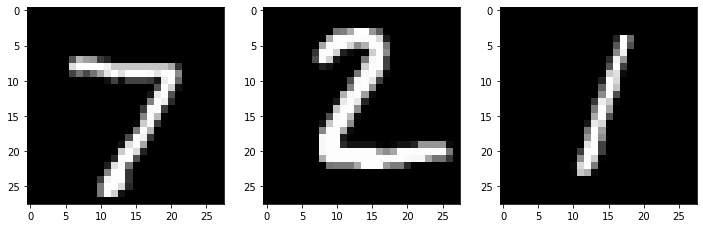

In [79]:
n = 3
plt.figure(figsize=(4*n, 4))
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray');

In [80]:
result = model.predict(test_images[:3])
result

1/1 [==============================] - 0s 27ms/step


array([[1.2666932e-05, 2.0766081e-06, 8.9961613e-05, 2.3048847e-04,
        1.0593973e-06, 4.2922252e-06, 5.7620571e-09, 9.9958640e-01,
        2.8205221e-07, 7.2888157e-05],
       [1.0388523e-03, 2.6441147e-03, 9.7992676e-01, 4.1258149e-03,
        1.1960913e-05, 3.0943803e-03, 8.4388889e-03, 1.0535882e-04,
        6.1116676e-04, 2.7001349e-06],
       [7.4418267e-08, 9.9727076e-01, 7.0017390e-04, 1.1825434e-04,
        5.4030814e-05, 9.9044635e-05, 9.6871961e-05, 1.5411350e-03,
        1.1699551e-04, 2.6427497e-06]], dtype=float32)

これらは各クラスタの確率となっている。一番大きな値をとったインデックスを取得する。

In [81]:
result.argmax(axis=-1)

array([7, 2, 1])

ちゃんとできている。テストデータでの正答率も求めてみる。

In [82]:
loss, acc = model.evaluate(test_images, test_labels, verbose=0)
print(f'loss:{loss}, acc:{acc}')

loss:0.21938154101371765, acc:0.9336000084877014


学習データと同じぐらいの値は取れているのでよし